### Authorship
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de<br>
- uses OSMNx, pandas, geopandas, rasterio
- may include content from ChatGPT or GitHub Copilot

### Features


# Imports

In [1]:
import pandas as pd
import geopandas as gpd

import os
from pathlib import Path
import fnmatch
import shutil

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from shapely.geometry.polygon import Polygon
from shapely.geometry import MultiLineString, LineString
import json

import rasterio
from rasterio import features
from rasterio.warp import reproject, calculate_default_transform, Resampling
from rasterio.mask import mask
from rasterio.plot import show, show_hist, plotting_extent
from scipy.ndimage import distance_transform_edt

import ee
import geemap
import logging

import random 

#from rasterstats import zonal_stats

import osmnx as ox

# init

In [3]:
#input a vector and a raster file for each city
AOI_path = Path('../data/processed/')
MUM_file = 'MUM_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.08.2024
MAN_file = 'MAN_LIM_reference_AOI_30m.shp' # APS: updated AOI 01.11.2024
JAK_file = 'JAK_LIM_reference_AOI_30m.shp' # APS: updated AOI 23.08.2024
#  the 'case_city' variable defines the city we are working on. APS: Need to update the code below to change it from MUM to the variable name

case_city = 'MAN' #MUM MAN JAK

if case_city == 'MUM':
    
    AOI_gdf = gpd.read_file(AOI_path / MUM_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MUM_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/MUM_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\TIFF_150m\\')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MUM\\model_inputs\\ASCII_150m')
    ti_city_ascii_path = Path('../model/MUM/data/in/')

    gadm_var = 'NAME_3'

if case_city == 'MAN':
    
    AOI_gdf = gpd.read_file(AOI_path / MAN_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/MAN_LIM_reference_AOI_30m.tif') # need to adapt this to the new SLEUTH AOI
    ref_raster_150_path = Path('../data/processed/MAN_LIM_reference_SLEUTH_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_150m\\')
    model_inputs_SLEUTH_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\TIFF_SLEUTH_150m')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_150m')
    ascii150_SLEUTH_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\MAN\\model_inputs\\ASCII_SLEUTH_150m')
    ti_city_ascii_path = Path('../model/MAN/data/in/')

    gadm_var = 'NAME_2'

if case_city == 'JAK':
    
    AOI_gdf = gpd.read_file(AOI_path / JAK_file) #.to_crs(epsg=4326)
    AOI_gdf_4326 = AOI_gdf.to_crs(epsg=4326) 

    ref_raster_path = Path('../data/processed/JAK_LIM_reference_AOI_30m.tif')
    ref_raster_150_path = Path('../data/processed/JAK_LIM_reference_AOI_150m.tif')

    raw_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\raw\\')
    interim_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\interim\\')
    processed_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\processed\\')
    external_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\external\\')
    model_inputs_30m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_30m\\')
    model_inputs_150m_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\TIFF_150m\\')
    ascii150_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\05_GIS_temp\\JAK\\model_inputs\\ASCII_150m')
    ti_city_ascii_path = Path('../model/JAK/data/in/')

    gadm_var = 'NAME_2'

external_data_path = Path(r'D:\\Dropbox\\x\\_data')
ascii150_arcgis_path = Path(r"D:\\Dropbox\\x\\PostDoc\ASCII_150m")

%run ./ti_city_00_raster_functions.ipynb

# read the reference raster
with rasterio.open(ref_raster_path,'r') as src:
    ref_raster = src
    ref_meta = src.meta
    ref_height, ref_width, ref_area = get_transform(ref_raster)



# suppress deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.tif'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.tif'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.tif'

discrete_list  = [real_estate_path,
                  case_city + '_LIM_districts_GADM4_150m.tif',
                  case_city + '_LIM_exclusion_layer_150m.tif',
                  #case_city + '_POP_census_income_150m.tif',
                  case_city + '_TRA_roads_OSM_2024_L_all_150m.tif',
                  case_city + '_URB_tenure_150m.tif',
                  case_city + '_URB_urbanisation_1985_EOC_WUF_150m.tif',
                  case_city + '_URB_urbanisation_2000_EOC_WUF_150m.tif',
                  case_city + '_URB_urbanisation_2015_EOC_WUF_150m.tif',
                  case_city + '_LIM_non_residential_areas_150m.tif']
continuous_list = [case_city + '_LOC_airports_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_airports_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_attractive_areas_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_attractive_areas_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_CBDs_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_CBDs_OSM_2024_distance_normal_150m.tif', 
                   case_city + '_LOC_health_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_health_OSM_2024_distance_normal_150m.tif',  
                   case_city + '_LOC_malls_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_malls_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_markets_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_markets_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_schools_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_schools_OSM_2024_distance_normal_150m.tif',
                   case_city + '_LOC_suburban_centres_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_suburban_centres_OSM_2024_distance_normal_150m.tif',
                   case_city + '_POP_density_normal_2000_WDPop_150m.tif',
                   case_city + '_POP_density_normal_2015_WDPop_150m.tif',
                   case_city + '_TRA_roads_OSM_2024_L_distance_normal_150m.tif',
                   case_city + '_URB_distance_urbanisation_2000_EOC_WUF_150m.tif',
                   case_city + '_URB_distance_urbanisation_2015_EOC_WUF_150m.tif',
                   case_city + '_HYD_water_distance_150m.tif']
slope_list=[case_city + '_DEM_slope_pct_TanDEM_X_150m.tif']

raster_list = [raster for raster in os.listdir(model_inputs_150m_path) if raster.endswith('.tif')]
for r in raster_list:
    if r in discrete_list or r in continuous_list or r in slope_list:
        print('r in list:', r)
    else: print('raster not in list:', r)

r in list: MAN_DEM_slope_pct_TanDEM_X_150m.tif
r in list: MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.tif
r in list: MAN_HYD_water_distance_150m.tif
r in list: MAN_LIM_districts_GADM4_150m.tif
r in list: MAN_LIM_exclusion_layer_150m.tif
r in list: MAN_LIM_non_residential_areas_150m.tif
r in list: MAN_LOC_airports_cost_OSM_2024.tif
r in list: MAN_LOC_attractive_areas_cost_OSM_2024.tif
r in list: MAN_LOC_CBDs_cost_OSM_2024.tif
r in list: MAN_LOC_health_cost_OSM_2024.tif
r in list: MAN_LOC_malls_cost_OSM_2024.tif
r in list: MAN_LOC_markets_cost_OSM_2024.tif
r in list: MAN_LOC_schools_cost_OSM_2024.tif
r in list: MAN_LOC_suburban_centres_cost_OSM_2024.tif
raster not in list: MAN_LOC_urbanisation2000_cost_OSM_2024.tif
raster not in list: MAN_LOC_urbanisation2015_cost_OSM_2024.tif
r in list: MAN_POP_density_normal_2000_WDPop_150m.tif
r in list: MAN_POP_density_normal_2015_WDPop_150m.tif
r in list: MAN_TRA_roads_OSM_2024_L_all_150m.tif
r in list: MAN_TRA_roads_OSM_2024_L_distance_normal_

# 1. clip to new AOI

In [12]:
for r in raster_list:
    if r in discrete_list:
        print(r, 'is in discrete_list')
        reproj_match(infile = model_inputs_150m_path / r, 
                     match = ref_raster_150_path, 
                     outfile = model_inputs_SLEUTH_150m_path / r, 
                     resampling=Resampling.nearest)
    elif (r in continuous_list) or (r in slope_list):
        print(r, 'is in continuous_list or slope_list')
        reproj_match(infile = model_inputs_150m_path / r, 
                     match = ref_raster_150_path, 
                     outfile = model_inputs_SLEUTH_150m_path / r, 
                     resampling=Resampling.bilinear)
    else: print('*** error ***',r, 'is not in any list')    

MAN_DEM_slope_pct_TanDEM_X_150m.tif is in continuous_list or slope_list
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.tif is in discrete_list
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
MAN_HYD_water_distance_150m.tif is in continuous_list or slope_list
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
MAN_LIM_districts_GADM4_150m.tif is in discrete_list
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
MAN_LIM_exclusion_layer_150m.tif is in discrete_list
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
MAN_LIM_non_residential_areas_150m.tif is in discrete_list
Coregistered to shape: 704 533 
 Affine | 150.0

# 2. create SSP exclusion layers

In [ ]:
sleuth_out_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\32 LIRLAP\\24 12 SLEUTH\\SSP_outputs\\')
sleuth_in_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\32 LIRLAP\\24 12 SLEUTH\\SSP_inputs\\')
sleuth_input = 'Int_manila_2022.tif'
sleuth_ssp1 = 'Int_SSP1_2050_tif'
sleuth_ssp2 = 'Int_SSP2_2050_tif'
sleuth_ssp3 = 'Int_SSP3_2050_tif'

sleuth_input_150 = model_inputs_SLEUTH_150m_path / 'MAN_URB_SLEUTH_input_2022.tif'
sleuth_ssp1_150 = model_inputs_SLEUTH_150m_path / 'MAN_URB_SLEUTH_SSP1_2050.tif'
sleuth_ssp2_150 = model_inputs_SLEUTH_150m_path / 'MAN_URB_SLEUTH_SSP2_2050.tif'
sleuth_ssp3_150 = model_inputs_SLEUTH_150m_path / 'MAN_URB_SLEUTH_SSP3_2050.tif'


reproj_match(infile = sleuth_in_path / sleuth_input, 
             match = ref_raster_150_path, 
             outfile = sleuth_input_150, 
             resampling=Resampling.nearest)

# resample the ssps to 150m
reproj_match(infile = sleuth_out_path / sleuth_ssp1, 
             match = ref_raster_150_path, 
             outfile = sleuth_ssp1_150, 
             resampling=Resampling.nearest)

reproj_match(infile = sleuth_out_path / sleuth_ssp2, 
             match = ref_raster_150_path, 
             outfile = sleuth_ssp2_150, 
             resampling=Resampling.nearest)

reproj_match(infile = sleuth_out_path / sleuth_ssp3, 
             match = ref_raster_150_path, 
             outfile = sleuth_ssp3_150, 
             resampling=Resampling.nearest)




Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|
Coregistered to shape: 704 533 
 Affine | 150.00, 0.00, 244017.74|
| 0.00,-150.00, 1659562.60|
| 0.00, 0.00, 1.00|


Unique values [0 1] 
Min value 0 , Type: int32


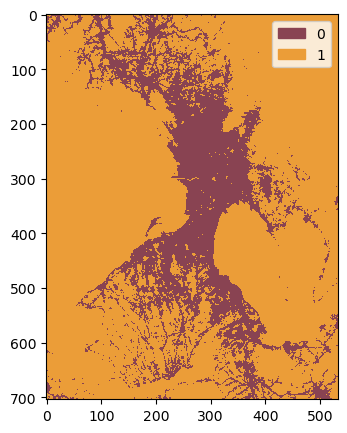

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\SLEUTH_inputs\TIFF_150m\MAN_LIM_exclusion_SLEUTH_SSP1_150m.tif
Unique values [0 1] 
Min value 0 , Type: int32


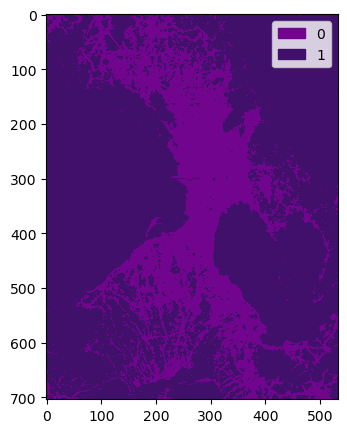

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\SLEUTH_inputs\TIFF_150m\MAN_LIM_exclusion_SLEUTH_SSP2_150m.tif
Unique values [0 1] 
Min value 0 , Type: int32


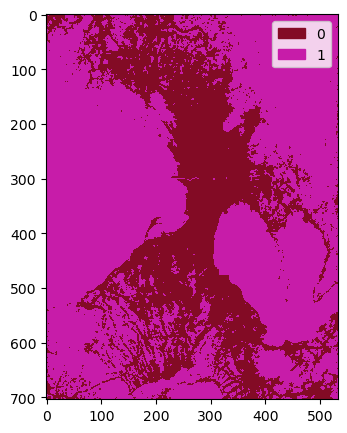

D:\Dropbox\x\PostDoc\23 10 LMU\13 exp_cases\24 01 Urban SSP MAN MUM JAK\05_GIS_temp\MAN\SLEUTH_inputs\TIFF_150m\MAN_LIM_exclusion_SLEUTH_SSP3_150m.tif


In [48]:
exclusion_file = case_city + '_LIM_exclusion_layer_150m.tif'
exclusion_path = model_inputs_SLEUTH_150m_path / exclusion_file

def new_exclusion(exclusion_path, ssp_path, plot=False, export=False, export_path=None):
    with rasterio.open(exclusion_path,'r') as exc:
        exclusion = exc.read(1)
        exclusion_meta = exc.meta
        exclusion_dtype = exclusion.dtype
        exclusion_transform = exc.transform
        with rasterio.open(ssp_path,'r') as src:
            ssp = src.read(1)
            ssp_meta = src.meta
            inverted_raster = np.where(ssp == 1, 0, 1)
            new_exclusion = exclusion + inverted_raster
            new_exclusion = np.where(new_exclusion == 2, 1, new_exclusion)
            if plot:
                plot_unique_value_raster(new_exclusion)
            if export:
                print(export_path)
                out_meta = exclusion_meta.copy()
                out_meta.update({"driver": "GTiff",
                     "dtype" : exclusion_dtype,
                     "height": out_meta['height'],
                     "width": out_meta['width'],
                     "transform": exclusion_transform})
                with rasterio.open(export_path, "w", **out_meta) as dest:
                    dest.write(new_exclusion.astype(exclusion_dtype), indexes=1)
            return new_exclusion
        
ssp1_exclusion = new_exclusion(exclusion_path = exclusion_path, 
                              ssp_path = sleuth_ssp1_150, 
                              plot=True,
                              export=True, 
                              export_path=model_inputs_SLEUTH_150m_path /'MAN_LIM_exclusion_SLEUTH_SSP1_150m.tif')
ssp1_exclusion = new_exclusion(exclusion_path = exclusion_path, 
                              ssp_path = sleuth_ssp2_150, 
                              plot=True,
                              export=True, 
                              export_path=model_inputs_SLEUTH_150m_path /'MAN_LIM_exclusion_SLEUTH_SSP2_150m.tif')
ssp1_exclusion = new_exclusion(exclusion_path = exclusion_path, 
                              ssp_path = sleuth_ssp3_150, 
                              plot=True,
                              export=True, 
                              export_path=model_inputs_SLEUTH_150m_path /'MAN_LIM_exclusion_SLEUTH_SSP3_150m.tif')


#ssp2_exclusion = new_excluion(exclusion_path, sleuth_ssp2_150)

#ssp3_exclusion = new_excluion(exclusion_path, sleuth_ssp3_150)



# 3. Convert cost layers into utility layers
This script opens the inputs to TI-City utility function and converts them to utility layers. This means layer values increase as utility increases (instead of their complement, as it featured in TI-City 1.0).

In [ ]:
## import cost layers

# set the environment for the model.
# calibrate =True means loading values for the initial year in the simulation (e.g. 2000)
# calibrate = False means loading values for the second time reference in the simulation (e.g. 2015)

calibrate = False

if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc'

cost_dict = {'attractive2000.asc': case_city + '_LOC_attractive_areas2000_cost_OSM_2024.tif', # APS: I need to replace this file with the actual 2000 data
             'attractive2015.asc': case_city + '_LOC_attractive_areas2015_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_attractive_areas_OSM_2024_distance_normal_150m.tif',
             'cbd.asc': case_city + '_LOC_CBDs_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_CBDs_OSM_2024_distance_normal_150m.tif', 
             'healthfacilities.asc': case_city + '_LOC_health_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_health_OSM_2024_distance_normal_150m.tif',  
             'shoppingmalls.asc': case_city + '_LOC_malls_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_malls_OSM_2024_distance_normal_150m.tif',
             'markets.asc': case_city + '_LOC_markets_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_markets_OSM_2024_distance_normal_150m.tif',
             'roads.asc': case_city + '_LOC_roads_cost_OSM_2024.tif', 
             'schools.asc': case_city + '_LOC_schools_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_schools_OSM_2024_distance_normal_150m.tif',
             'suburban.asc': case_city + '_LOC_suburban_centres_cost_OSM_2024.tif', # APS: until 06/03/2025 '_LOC_suburban_centres_OSM_2024_distance_normal_150m.tif',
             'bu2000_dist.asc': case_city + '_LOC_urbanisation2000_cost_150m.tif', 
             'bu2015_dist.asc': case_city + '_LOC_urbanisation2015_cost_150m.tif',  
             'density2000.asc': case_city + '_pop_density_normal_2000_wdpop_150m.tif', # APS: need to replace this file with the actual 2000 data _pop_density_normal_2000_wdpop_150m
             'density2015.asc': case_city + '_pop_density_normal_2015_wdpop_150m.tif', 
             'water.asc': case_city + '_LOC_water_cost_OSM_2024.tif'
}

no_file_list = []
ut_raster_dict = {}

for ascii, tiff in cost_dict.items():
    
    layer = ascii.split('.')[0]
    file_name = tiff
    print(layer,':', file_name)
    if file_name != None:
        url = model_inputs_SLEUTH_150m_path / file_name
        #print(layer,url)
    else:
        url = None
    
    try:
        with rasterio.open(url) as src:
            raster = src.read(1)
            # calculate the complement of cost layers
            #if (layer != 'bu2000_dist') and (layer != 'bu2015_dist'):    
            if (layer != 'density2000') and (layer != 'density2015'):
                raster = np.where(raster <= 0, np.nanmax(raster), raster)
                raster_complement = 1 - raster
                raster = raster_complement
            else:
                raster = np.where(raster <= 0, 0, raster)
            # normalize the raster values if they are greater than 1
            if np.nanmax(raster) > 1:
                raster = (raster - np.nanmin(raster))/(np.nanmax(raster) - np.nanmin(raster))
                            
            ut_raster_dict[layer] = raster
            #print(layer,'shape:',raster.shape)
    except:
        print('***',layer,'has no file')
        no_file_list.append(layer)
print(' ')    
#print('create stand-in rasters for:',no_file_list)

for key, value in ut_raster_dict.items():
    print(key, value.shape, 'min:', np.nanmin(value), 'max:', np.nanmax(value))


attractive2000 : MAN_LOC_attractive_areas2000_cost_OSM_2024.tif
*** attractive2000 has no file
attractive2015 : MAN_LOC_attractive_areas2015_cost_OSM_2024.tif
cbd : MAN_LOC_CBDs_cost_OSM_2024.tif
healthfacilities : MAN_LOC_health_cost_OSM_2024.tif
shoppingmalls : MAN_LOC_malls_cost_OSM_2024.tif
markets : MAN_LOC_markets_cost_OSM_2024.tif
roads : MAN_LOC_roads_cost_OSM_2024.tif
schools : MAN_LOC_schools_cost_OSM_2024.tif
suburban : MAN_LOC_suburban_centres_cost_OSM_2024.tif
bu2000_dist : MAN_LOC_urbanisation2000_cost_150m.tif
bu2015_dist : MAN_LOC_urbanisation2015_cost_150m.tif
density2000 : MAN_pop_density_normal_2000_wdpop_150m.tif
*** density2000 has no file
density2015 : MAN_pop_density_normal_2015_wdpop_150m.tif
water : MAN_LOC_water_cost_OSM_2024.tif
 
attractive2015 (704, 533) min: 0.0 max: 0.99607843
cbd (704, 533) min: 0.0 max: 0.99607843
healthfacilities (704, 533) min: 0.0 max: 0.99607843
shoppingmalls (704, 533) min: 0.0 max: 0.99607843
markets (704, 533) min: 0.0 max: 0.996

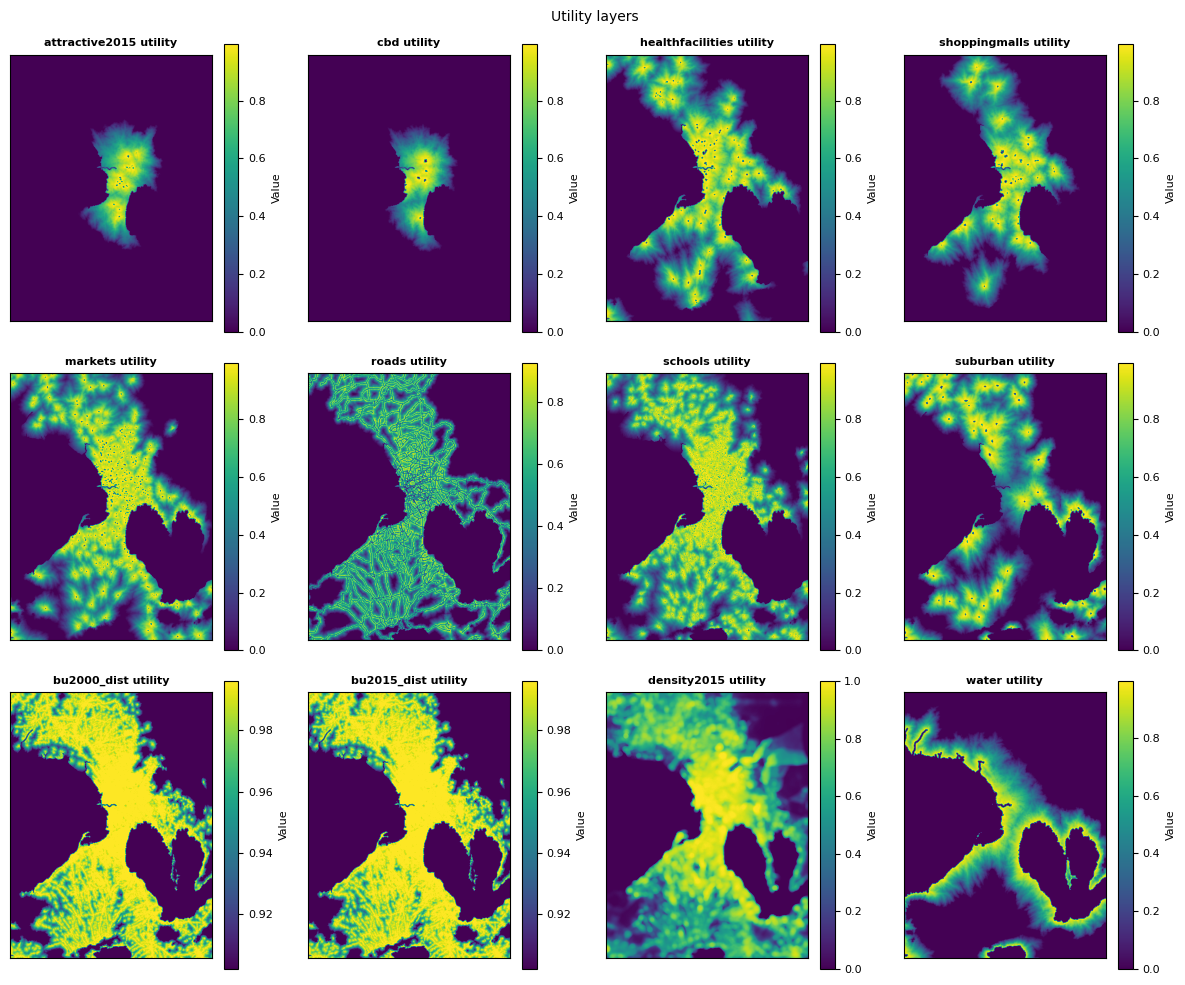

In [16]:
plot_many_rasters(raster_dict=ut_raster_dict, 
                  fig_title='Utility layers', 
                  ref_raster_path=ref_raster_150_path, 
                  subplot_title=' utility')

# 4. Export TIFFs as ASCIIs

## 4.1 Export utility rasters + other files

In [17]:
# export the utility rasters calculated above as ASCII files
%run ./ti_city_00_raster_functions.ipynb
for key, value in ut_raster_dict.items():
    file_name = cost_dict[str(key) + '.asc'].replace('.tif','.asc')
    export_path = ascii150_SLEUTH_path / file_name
    #print(file_name, export_path)
    try:
        #raster_obj = np.where(raster_obj <= 0, -9999, raster_obj)
        export_raster_to_ascii(raster_obj = value,
                            export_path = export_path, 
                            ref_raster_path = ref_raster_150_path,
                            raster_data_type= 'float64') #r.dtypes[0]
        print(str(export_path).split('\\')[-1], 'exported')
    except:
        print('*** error ***', key, 'not exported')
    
        

MAN_LOC_attractive_areas2015_cost_OSM_2024.asc exported
MAN_LOC_CBDs_cost_OSM_2024.asc exported
MAN_LOC_health_cost_OSM_2024.asc exported
MAN_LOC_malls_cost_OSM_2024.asc exported
MAN_LOC_markets_cost_OSM_2024.asc exported
MAN_LOC_roads_cost_OSM_2024.asc exported
MAN_LOC_schools_cost_OSM_2024.asc exported
MAN_LOC_suburban_centres_cost_OSM_2024.asc exported
MAN_LOC_urbanisation2000_cost_150m.asc exported
MAN_LOC_urbanisation2015_cost_150m.asc exported
MAN_pop_density_normal_2015_wdpop_150m.asc exported
MAN_LOC_water_cost_OSM_2024.asc exported


In [54]:
# export the remaining rasters

non_utility_dict = {'slope.asc': case_city + '_DEM_slope_pct_TanDEM_X_150m.asc', 
                 'exclusion.asc': case_city + '_lim_exclusion_layer_150m.asc', 
                 'districts.asc': case_city + '_lim_districts_gadm4_150m.asc',
                 'structureplan.asc': case_city + '_LIM_non_residential_areas_150m.asc', # APS: MUM and JAK still need defining
                 #'income.asc': case_city + '_pop_census_income_150m.asc',  # APS 18.11.2024 Need to estimate for Manila
                 'airport.asc': case_city + '_LOC_airports_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_airports_OSM_2024_distance_normal_150m.tif',
                 'tenure.asc': case_city + '_urb_tenure_150m.asc', 
                 'density2000.asc': case_city + '_POP_density_normal_2000_WDPop_150m.asc',
                 'density2015.asc': case_city + '_POP_density_normal_2015_WDPop_150m.asc', 
                 'landvalue.asc': real_estate_path,
                 'road-presence.asc': case_city + '_TRA_roads_OSM_2024_all_150m.asc', 
                 'urban2000.asc': case_city + '_urb_urbanisation_2000_eoc_wuf_150m.asc', 
                 'urban2015.asc': case_city + '_urb_urbanisation_2015_eoc_wuf_150m.asc'                 
}

for key, value in non_utility_dict.items():
    ascii_name = str(value)
    tiff_name = str(value).replace('.asc','.tif')
    source_path = model_inputs_SLEUTH_150m_path / tiff_name
    export_path = ascii150_SLEUTH_path / ascii_name
    #print('source:',source_path, '\n> export:',export_path)
    try:
        with rasterio.open(source_path) as src:
            raster_obj = src.read(1)
            #print(raster_obj.shape)      
            export_raster_to_ascii(raster_obj = raster_obj,
                                   export_path = export_path, 
                                   ref_raster_path = ref_raster_150_path,
                                   raster_data_type=src.dtypes[0]) #r.
            print(str(export_path).split('\\')[-1], 'exported')
    except:
        print('***', key, 'not exported')



MAN_DEM_slope_pct_TanDEM_X_150m.asc exported
MAN_lim_exclusion_layer_150m.asc exported
MAN_lim_districts_gadm4_150m.asc exported
MAN_LIM_non_residential_areas_150m.asc exported
MAN_LOC_airports_cost_OSM_2024.asc exported
MAN_urb_tenure_150m.asc exported
*** density2000.asc not exported
MAN_POP_density_normal_2015_WDPop_150m.asc exported
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc exported
MAN_TRA_roads_OSM_2024_all_150m.asc exported
MAN_urb_urbanisation_2000_eoc_wuf_150m.asc exported
MAN_urb_urbanisation_2015_eoc_wuf_150m.asc exported


## 4.2 Alternatively, export all the TIFFs in the model folder as ASCII

In [ ]:
%run ./ti_city_00_raster_functions.ipynb
raster_list = [raster for raster in os.listdir(model_inputs_SLEUTH_150m_path) if raster.endswith('.tif')]

for raster in raster_list: 
    file_name = str(raster.replace('.tif', '.asc'))
    export_path = ascii150_SLEUTH_path / file_name
    
    with rasterio.open(model_inputs_SLEUTH_150m_path/raster, 'r') as r:
        raster_obj = r.read(1)
        #raster_obj = np.where(raster_obj <= 0, -9999, raster_obj)
        export_raster_to_ascii(raster_obj = raster_obj,
                            export_path = export_path, 
                            ref_raster_path = ref_raster_150_path,
                            raster_data_type= 'float64') #r.dtypes[0]
    print(str(export_path).split('\\')[-1], 'exported')
print('done')

MAN_DEM_slope_pct_TanDEM_X_150m.asc exported
MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc exported
MAN_LIM_districts_GADM4_150m.asc exported
MAN_LIM_exclusion_layer_150m.asc exported
MAN_LIM_exclusion_SLEUTH_SSP1_150m.asc exported
MAN_LIM_exclusion_SLEUTH_SSP2_150m.asc exported
MAN_LIM_exclusion_SLEUTH_SSP3_150m.asc exported
MAN_LIM_non_residential_areas_150m.asc exported
MAN_LIM_reference_SLEUTH_AOI_150m.asc exported
MAN_LOC_airports_cost_OSM_2024.asc exported
MAN_LOC_attractive_areas_cost_OSM_2024.asc exported
MAN_LOC_CBDs_cost_OSM_2024.asc exported
MAN_LOC_health_cost_OSM_2024.asc exported
MAN_LOC_malls_cost_OSM_2024.asc exported
MAN_LOC_markets_cost_OSM_2024.asc exported
MAN_LOC_roads_cost_OSM_2024.asc exported
MAN_LOC_schools_cost_OSM_2024.asc exported
MAN_LOC_suburban_centres_cost_OSM_2024.asc exported
MAN_LOC_urbanisation2000_cost_150m.asc exported
MAN_LOC_urbanisation2015_cost_150m.asc exported
MAN_LOC_water_cost_OSM_2024.asc exported
MAN_POP_density_normal_2015_WDPop_1

# 5. Rename and copy to the model folder

In [18]:
# build a renaming dictionary between the arcgis exports in the arcgis_ascii_files list and the TI City model inputs in the ti_city_files list
if case_city == 'MUM':
    real_estate_path = 'MUM_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'JAK':
    real_estate_path = 'JAK_ECO_real_estate_sale_LePetit_extended_2019_150m.asc'
if case_city == 'MAN':
    real_estate_path = 'MAN_ECO_real_estate_EBK_Lamudi_reclass_2024_150m.asc'

renaming_dict = {'slope.asc': case_city + '_DEM_slope_pct_TanDEM_X_150m.asc', 
                 'exclusion.asc': case_city + '_lim_exclusion_layer_150m.asc', 
                 'districts.asc': case_city + '_lim_districts_gadm4_150m.asc',
                 'structureplan.asc': case_city + '_LIM_non_residential_areas_150m.asc', # APS: MUM and JAK still need defining
                 #'income.asc': case_city + '_pop_census_income_150m.asc',  # APS 18.11.2024 Need to estimate for Manila
                 'airport.asc': case_city + '_LOC_airports_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_airports_OSM_2024_distance_normal_150m.tif',
                 'attractive2000.asc': case_city + '_LOC_attractive_areas2000_cost_OSM_2024.asc', # APS: I need to replace this file with the actual 2000 data
                 'attractive2015.asc': case_city + '_LOC_attractive_areas2015_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_attractive_areas_OSM_2024_distance_normal_150m.tif',
                 'cbd.asc': case_city + '_LOC_CBDs_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_CBDs_OSM_2024_distance_normal_150m.tif', 
                 'healthfacilities.asc': case_city + '_LOC_health_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_health_OSM_2024_distance_normal_150m.tif',  
                 'shoppingmalls.asc': case_city + '_LOC_malls_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_malls_OSM_2024_distance_normal_150m.tif',
                 'markets.asc': case_city + '_LOC_markets_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_markets_OSM_2024_distance_normal_150m.tif',
                 'schools.asc': case_city + '_LOC_schools_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_schools_OSM_2024_distance_normal_150m.tif',
                 'suburban.asc': case_city + '_LOC_suburban_centres_cost_OSM_2024.asc', # APS: until 06/03/2025 '_LOC_suburban_centres_OSM_2024_distance_normal_150m.tif',
                 'roads.asc': case_city + '_LOC_roads_cost_OSM_2024.asc', 
                 'bu2000_dist.asc': case_city + '_LOC_urbanisation2000_cost_150m.asc', 
                 'bu2015_dist.asc': case_city + '_LOC_urbanisation2015_cost_150m.asc', 
                 'tenure.asc': case_city + '_urb_tenure_150m.asc', 
                 'density2000.asc': case_city + '_POP_density_normal_2000_WDPop_150m.asc',
                 'density2015.asc': case_city + '_POP_density_normal_2015_WDPop_150m.asc', 
                 'landvalue.asc': real_estate_path,
                 'road-presence.asc': case_city + '_TRA_roads_OSM_2024_all_150m.asc', 
                 'urban2000.asc': case_city + '_urb_urbanisation_2000_eoc_wuf_150m.asc', 
                 'urban2015.asc': case_city + '_urb_urbanisation_2015_eoc_wuf_150m.asc',
                 'water.asc': case_city + '_LOC_water_cost_OSM_2024.asc'
}

# rasters not included in the above correpondence (yet): income, 1 files are 'stand-ins'

In [19]:
# code adapted from https://www.geeksforgeeks.org/python-shutil-copyfile-method/

success_list = []
fail_list = []
for key in renaming_dict.keys():
    source = ascii150_SLEUTH_path / renaming_dict[key]
    dest = ti_city_ascii_path / key
    
    try :
        shutil.copyfile(source, dest)
        success_list.append(dest)
    
    # If Source is a file but destination is a directory
    except IsADirectoryError:
        print("Source is a file but destination is a directory.")
        fail_list.append(dest)
    
    # If source and destination are same
    except shutil.SameFileError:
        print("Source and destination represents the same file.")
        fail_list.append(dest)

    # If source is a directory but destination is a file
    except NotADirectoryError:
        print("Source is a directory but destination is a file.")
        fail_list.append(dest)
    
    # For permission related errors
    except PermissionError:
        print("Operation not permitted.")
        fail_list.append(dest)
    
    # For other errors
    except:
        print("Error occurred while copying file:\n", renaming_dict[key])
        fail_list.append(dest)
print('Tried to copy:', len(renaming_dict), 'files\n', 'Succesfully copied:', len(success_list), 'files\n','The files copied were:',)
print('\n'.join(''.join(str(sl)) for sl in success_list))
if len(fail_list) > 0:
    print('Failed to copy:', len(fail_list), 'files\n','The files not copied were:')
    print('\n'.join(''.join(str(sl)) for sl in fail_list))

Error occurred while copying file:
 MAN_LOC_attractive_areas2000_cost_OSM_2024.asc
Error occurred while copying file:
 MAN_POP_density_normal_2000_WDPop_150m.asc
Tried to copy: 24 files
 Succesfully copied: 22 files
 The files copied were:
..\model\MAN\data\in\slope.asc
..\model\MAN\data\in\exclusion.asc
..\model\MAN\data\in\districts.asc
..\model\MAN\data\in\structureplan.asc
..\model\MAN\data\in\airport.asc
..\model\MAN\data\in\attractive2015.asc
..\model\MAN\data\in\cbd.asc
..\model\MAN\data\in\healthfacilities.asc
..\model\MAN\data\in\shoppingmalls.asc
..\model\MAN\data\in\markets.asc
..\model\MAN\data\in\schools.asc
..\model\MAN\data\in\suburban.asc
..\model\MAN\data\in\roads.asc
..\model\MAN\data\in\bu2000_dist.asc
..\model\MAN\data\in\bu2015_dist.asc
..\model\MAN\data\in\tenure.asc
..\model\MAN\data\in\density2015.asc
..\model\MAN\data\in\landvalue.asc
..\model\MAN\data\in\road-presence.asc
..\model\MAN\data\in\urban2000.asc
..\model\MAN\data\in\urban2015.asc
..\model\MAN\data\i

# The end (for now).

## NetLogo scripts (for reference/development)
just holding them here for now

In [ ]:
(count households with [(income-status = 1) and (LIH-movement = 0)] ) # LI HH left
(count households with [(income-status = 2) and (MIH-movement = 0)] ) # MI HH left
(count households with [(income-status = 3) and (HIH-movement = 0)] ) # HI HH left
(count households with [(income-status = 4) and (DPH-movement = 0)] ) # deprived HH left

In [ ]:
plot ((count patches with [DP-movement = 1 and new-urban = 1]) / (1 + count patches with [ new-urban = 1])) * 100
plot ((count patches with [DP-movement = 1 and informality = 1]) / (1 + count patches with [DP-movement = 1])) * 100
plot ((count patches with [DP-movement = 1 and informal_avail = 1]) / (1 + count patches with [ new-urban = 1 and informal_avail = 1])) * 100

In [ ]:
plot ((count patches with [LI-movement = 1 and new-urban = 1]) / (1 + count patches with [ new-urban = 1])) * 100
plot (((count patches with [MI-movement = 1 and new-urban = 1]) + (count patches with [pMED-movement = 1 and new-urban = 1])) / (1 + count patches with [ new-urban = 1 ])) * 100
plot (((count patches with [HI-movement = 1 and new-urban = 1]) + (count patches with [pHED-movement = 1 and new-urban = 1])) / (1 + count patches with [ new-urban = 1 ])) * 100

In [ ]:
plot (((count patches with [HI-movement = 1 and informality = 1]) + (count patches with [pHED-movement = 1 and informality = 1])) / ((1 + count patches with [HI-movement = 1]) + (count patches with [pHED-movement = 1]))) * 100
plot (((count patches with [MI-movement = 1 and informality = 1]) + (count patches with [pMED-movement = 1 and informality = 1])) / ((1 + count patches with [MI-movement = 1]) + (count patches with [pMED-movement = 1]))) * 100

In [ ]:
(ifelse 
    scenario = "standard" 
    [ 
      ] ;; standard true
    [ ifelse scenario = "SSP1" ;; else
      [ 
        ] ;; SSP1 true (standard false)
      [ ifelse scenario = "SSP2" ;; else
        [ 
          ] ;; SSP2 true 
        [ if scenario = "SSP3" ;; else
          [  
            ] ;; SSP3 true 
        ] ;; SSP3 false
      ] ;; SSP2 false
    ] ;; SSP1 false
  )

In [ ]:
(ifelse 
    scenario = "standard" 
    [ set 
     [ household-number percent-deprived-households percent-low-income-households percent-mid-income-households percent-high-income-households slope_coefficient critical_slope development_control] 
     [ 23959 10 30 50 10 80 17 50 ]
      ] ;; standard true
    [ ifelse scenario = "SSP1" ;; standard else
      [ set 
       [ household-number percent-deprived-households percent-low-income-households percent-mid-income-households percent-high-income-households slope_coefficient critical_slope development_control] 
       [ 31677 7 21 55 17 80 17 80 ] 
        ] ;; SSP1 true (standard false)
      [ ifelse scenario = "SSP2" ;; SSP1 else
       [ set
        [ household-number percent-deprived-households percent-low-income-households percent-mid-income-households percent-high-income-households slope_coefficient critical_slope development_control] 
        [ 51168 10 30 50 10 80 25 50 ] 
        ]  ;; SSP2 true 
        [ if scenario = "SSP3" ;; SSP2 else
         [ set 
          [ household-number percent-deprived-households percent-low-income-households percent-mid-income-households percent-high-income-households slope_coefficient critical_slope development_control] 
          [ 71629 17 48 28 7 80 35 30 ] 
        ] ;; SSP3 true 
        ] ;; closing SSP3
      ] ;; closing SSP2 
    ] ;; closing SSP1 
)